In [151]:
import numpy as np

# Inputs
center_lat = 21.0635
center_lon = 72.8972
img_size = 128
gsd = 10  # meters per pixel, adjust if not 10m
coords = [0.482447, 0.356692, 0.532411, 0.356692, 0.532411, 0.307417, 0.482447, 0.307417]
points = np.array(coords).reshape(4, 2) * img_size

latlons = []
for x, y in points:
    dx = x - img_size / 2
    dy = y - img_size / 2
    dx_m = dx * gsd
    dy_m = dy * gsd
    dlat = dy_m / 111320
    dlon = dx_m / (111320 * np.cos(np.deg2rad(center_lat)))
    lat = center_lat + dlat
    lon = center_lon + dlon
    latlons.append((lat, lon))

for i, (lat, lon) in enumerate(latlons):
    print(f"Corner {i+1}: lat={lat:.6f}, lon={lon:.6f}")


Corner 1: lat=21.061852, lon=72.896984
Corner 2: lat=21.061852, lon=72.897599
Corner 3: lat=21.061286, lon=72.897599
Corner 4: lat=21.061286, lon=72.896984


In [188]:
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

def get_latlon_corners(center_lat, center_lon, points, img_size=128, gsd=10):
    latlons = []
    for x, y in points:
        dx = x - img_size / 2
        dy = y - img_size / 2
        dx_m = dx * gsd
        dy_m = dy * gsd
        dlat = dy_m / 111320
        dlon = dx_m / (111320 * np.cos(np.deg2rad(center_lat)))
        lat = center_lat + dlat
        lon = center_lon + dlon
        latlons.append((lon, lat))
    return latlons

folder = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/test/yolo_obb_labels"
data = []

for fname in os.listdir(folder):
    if fname.endswith('.txt'):
        image_name = fname.replace('.txt', '.png')
        # Extract lat/lon from filename
        lat_str, lon_str = image_name.replace('.png', '').split('_')
        center_lat = float(lat_str)
        center_lon = float(lon_str)
        label_path = os.path.join(folder, fname)
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 9:
                    continue
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))
                points = np.array(coords).reshape(4,2) * 128
                latlons = get_latlon_corners(center_lat, center_lon, points)
                poly = Polygon(latlons)
                data.append({
                    'image_name': image_name,
                    'class': class_id,
                    'geometry': poly
                })

gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")
print("total",len(gdf))

total 21100


In [189]:
gdf

,image_name,class,geometry
0,31.3041_72.9763.png,1,"POLYGON ((72.97739 31.30321, 72.97819 31.3025,..."
1,25.5144_82.5985.png,2,"POLYGON ((82.59778 25.511, 82.59799 25.5104, 8..."
2,24.3004_88.3018.png,2,"POLYGON ((88.29608 24.30285, 88.29632 24.30219..."
3,26.2539_85.2612.png,2,"POLYGON ((85.26427 26.25824, 85.26483 26.25824..."
4,29.8292_74.6382.png,2,"POLYGON ((74.64022 29.83173, 74.64184 29.83167..."
...,...,...,...
21095,27.7644_81.4985.png,1,"POLYGON ((81.49361 27.76389, 81.49459 27.76338..."
21096,29.6643_77.2661.png,2,"POLYGON ((77.27013 29.66882, 77.27055 29.6685,..."
21097,25.9761_88.6232.png,2,"POLYGON ((88.62826 25.97504, 88.62855 25.97441..."
21098,27.4379_80.3073.png,1,"POLYGON ((80.31166 27.43625, 80.31214 27.4354,..."


In [190]:
import geopandas as gpd

gdf = gdf.reset_index(drop=True)
sindex = gdf.sindex

overlap_idx = set()

for idx, geom in enumerate(gdf.geometry):
    # Find possible overlapping candidates using bounding box intersection
    possible_matches = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches:
        if other_idx == idx:
            continue
        other_geom = gdf.geometry.iloc[other_idx]
        if geom.intersects(other_geom):
            overlap_idx.add(idx)
            overlap_idx.add(other_idx)

gdf['group'] = 'unique'
gdf.loc[list(overlap_idx), 'group'] = 'common'

print("Common geometries:", (gdf['group'] == 'common').sum())
print("Unique geometries:", (gdf['group'] == 'unique').sum())


Common geometries: 1284
Unique geometries: 19816


In [200]:
import geopandas as gpd

gdf = gdf.reset_index(drop=True)
sindex = gdf.sindex
common_idx = set()

for idx, geom in enumerate(gdf.geometry):
    possible_matches = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches:
        if other_idx == idx:
            continue
        other_geom = gdf.geometry.iloc[other_idx]
        if geom.intersects(other_geom):
            intersection_area = geom.intersection(other_geom).area
            union_area = geom.union(other_geom).area
            min_area = min(geom.area, other_geom.area)
            # Check for >10% overlap in either metric
            if min_area > 0 and intersection_area / min_area > 0.99:
                common_idx.add(idx)
                common_idx.add(other_idx)
            elif union_area > 0 and intersection_area / union_area > 0.99:
                common_idx.add(idx)
                common_idx.add(other_idx)

gdf['group'] = 'unique'
gdf.loc[list(common_idx), 'group'] = 'common'

print("Common geometries (overlap/intersection >10%):", (gdf['group'] == 'common').sum())
print("Unique geometries:", (gdf['group'] == 'unique').sum())


Common geometries (overlap/intersection >10%): 2
Unique geometries: 21098


In [164]:
# For each geometric predicate: 'intersects', 'touches', 'contains', 'within', 'crosses'


joined = gpd.sjoin(gdf[['geometry']], gdf[['geometry']], how='inner', predicate="intersects")
joined = joined[joined.index != joined['index_right']]
idx_set = set(joined.index) | set(joined['index_right'])
print(f"{len(idx_set)} geometries involved")
print(f"{len(gdf) - len(idx_set)} geometries not involved\n")



1284 geometries involved
19816 geometries not involved



In [159]:
import geopandas as gpd

# Spatial join using 'touches'
joined = gpd.sjoin(gdf, gdf, how='inner', predicate='touches')
print(joined)
# Remove self-joins
joined = joined[joined.index != joined['index_right']]

# Mark touching polygons
touching_idx = set(joined.index) | set(joined['index_right'])
gdf['touch_group'] = 'not_touching'
gdf.loc[list(touching_idx), 'touch_group'] = 'touching'

touching_gdf = gdf[gdf['touch_group'] == 'touching']
not_touching_gdf = gdf[gdf['touch_group'] == 'not_touching']

print("Touching geometries count:", len(touching_gdf))
print("Not touching geometries count:", len(not_touching_gdf))


Empty GeoDataFrame
Columns: [image_name_left, class_left, geometry, group_left, touch_group_left, index_right, image_name_right, class_right, group_right, touch_group_right]
Index: []
Touching geometries count: 0
Not touching geometries count: 21100


In [146]:
classwise_common = common_gdf.groupby('class').size()
print("Class-wise common geometries count:")
print(classwise_common)


Class-wise common geometries count:
class
0     20
1    337
2    328
dtype: int64


In [149]:
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

def get_latlon_corners(center_lat, center_lon, points, img_size=128, gsd=10):
    latlons = []
    for x, y in points:
        dx = x - img_size / 2
        dy = y - img_size / 2
        dx_m = dx * gsd
        dy_m = dy * gsd
        dlat = dy_m / 111320
        dlon = dx_m / (111320 * np.cos(np.deg2rad(center_lat)))
        lat = center_lat + dlat
        lon = center_lon + dlon
        latlons.append((lon, lat))
    return latlons

folder = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/train/yolo_obb_labels"
data = []

for fname in os.listdir(folder):
    if fname.endswith('.txt'):
        image_name = fname.replace('.txt', '.png')
        lat_str, lon_str = image_name.replace('.png', '').split('_')
        center_lat = float(lat_str)
        center_lon = float(lon_str)
        label_path = os.path.join(folder, fname)
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 9:
                    continue
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))
                points = np.array(coords).reshape(4,2) * 128
                latlons = get_latlon_corners(center_lat, center_lon, points)
                poly = Polygon(latlons)
                data.append({
                    'image_name': image_name,
                    'class': class_id,
                    'geometry': poly
                })

gdf_train = gpd.GeoDataFrame(data, crs="EPSG:4326")
print("class count",gdf_train.groupby('class').size())
# Spatial join using 'intersects'
joined = gpd.sjoin(gdf_train, gdf_train, how='inner', predicate='intersects')

# Remove self-joins
joined = joined[joined.index != joined['index_right']]

# Compute overlap: intersection area / min(poly1.area, poly2.area)
def overlap_ratio(row):
    poly1 = gdf_train.loc[row.name].geometry
    poly2 = gdf_train.loc[row['index_right']].geometry
    inter = poly1.intersection(poly2).area
    min_area = min(poly1.area, poly2.area)
    return inter / min_area if min_area > 0 else 0

joined['overlap_ratio'] = joined.apply(overlap_ratio, axis=1)

# Find indices of all polygons with >=30% overlap with any other
common_idx = set(joined[joined['overlap_ratio'] >= 0.5].index) | set(joined[joined['overlap_ratio'] >= 0.5]['index_right'])
gdf_train['group'] = 'unique'
gdf_train.loc[list(common_idx), 'group'] = 'common'

unique_gdf = gdf_train[gdf_train['group'] == 'unique']
common_gdf = gdf_train[gdf_train['group'] == 'common']

print("Unique geometries count:", len(unique_gdf))
print("Common geometries count:", len(common_gdf))

# Class-wise common geometry count
classwise_common = common_gdf.groupby('class').size()

print("Class-wise common geometries count:")
print("Train set:",classwise_common)


class count class
0     2032
1    34292
2    27463
dtype: int64
Unique geometries count: 60596
Common geometries count: 3191
Class-wise common geometries count:
Train set: class
0     201
1    1597
2    1393
dtype: int64


In [150]:
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

def get_latlon_corners(center_lat, center_lon, points, img_size=128, gsd=10):
    latlons = []
    for x, y in points:
        dx = x - img_size / 2
        dy = y - img_size / 2
        dx_m = dx * gsd
        dy_m = dy * gsd
        dlat = dy_m / 111320
        dlon = dx_m / (111320 * np.cos(np.deg2rad(center_lat)))
        lat = center_lat + dlat
        lon = center_lon + dlon
        latlons.append((lon, lat))
    return latlons

folder = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/val/yolo_obb_labels"
data = []

for fname in os.listdir(folder):
    if fname.endswith('.txt'):
        image_name = fname.replace('.txt', '.png')
        lat_str, lon_str = image_name.replace('.png', '').split('_')
        center_lat = float(lat_str)
        center_lon = float(lon_str)
        label_path = os.path.join(folder, fname)
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 9:
                    continue
                class_id = int(parts[0])
                coords = list(map(float, parts[1:]))
                points = np.array(coords).reshape(4,2) * 128
                latlons = get_latlon_corners(center_lat, center_lon, points)
                poly = Polygon(latlons)
                data.append({
                    'image_name': image_name,
                    'class': class_id,
                    'geometry': poly
                })

gdf_val = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Spatial join using 'intersects'
joined = gpd.sjoin(gdf_val, gdf_val, predicate='contains')

# Remove self-joins
joined = joined[joined.index != joined['index_right']]

# Compute overlap: intersection area / min(poly1.area, poly2.area)
def overlap_ratio(row):
    poly1 = gdf_val.loc[row.name].geometry
    poly2 = gdf_val.loc[row['index_right']].geometry
    inter = poly1.intersection(poly2).area
    min_area = min(poly1.area, poly2.area)
    return inter / min_area if min_area > 0 else 0

joined['overlap_ratio'] = joined.apply(overlap_ratio, axis=1)

# Find indices of all polygons with >=30% overlap with any other
common_idx = set(joined[joined['overlap_ratio'] >= 0.03].index) | set(joined[joined['overlap_ratio'] >= 0.3]['index_right'])
gdf_val['group'] = 'unique'
gdf_val.loc[list(common_idx), 'group'] = 'common'

unique_gdf = gdf_val[gdf_val['group'] == 'unique']
common_gdf = gdf_val[gdf_val['group'] == 'common']

print("Unique geometries count:", len(unique_gdf))
print("Common geometries count:", len(common_gdf))

# Class-wise common geometry count
classwise_common = common_gdf.groupby('class').size()
print("Class-wise common geometries count:")
print("val set:",classwise_common)


ValueError: Cannot set a DataFrame with multiple columns to the single column overlap_ratio

In [137]:
import geopandas as gpd

def find_common_indices(gdf1, gdf2, threshold=0.50):
    join = gpd.sjoin(gdf1, gdf2, how='inner', predicate='intersects')
    join = join[join.index != join['index_right']]
    def ratio(row):
        poly1 = gdf1.loc[row.name].geometry
        poly2 = gdf2.loc[row['index_right']].geometry
        inter = poly1.intersection(poly2).area
        min_area = min(poly1.area, poly2.area)
        return inter / min_area if min_area > 0 else 0
    join['overlap_ratio'] = join.apply(ratio, axis=1)
    return set(join[join['overlap_ratio'] >= threshold].index)

train_val_common = find_common_indices(gdf_train, gdf_val)
train_test_common = find_common_indices(gdf_train, gdf)
val_test_common = find_common_indices(gdf_val, gdf)

print("Common instances (≥30% overlap):")
print(f"Train/Val: {len(train_val_common)}")
print(f"Train/Test: {len(train_test_common)}")
print(f"Val/Test: {len(val_test_common)}")


Common instances (≥30% overlap):
Train/Val: 997
Train/Test: 1050
Val/Test: 337


In [125]:
common_in_all_three = train_val_common & train_test_common
print("Instances common in all three splits:", len(common_in_all_three))


Instances common in all three splits: 2


In [256]:
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
def get_latlon_corners(center_lat, center_lon, points, img_size=128, gsd=10):
    latlons = []
    for x, y in points:
        dx = x - img_size / 2
        dy = y - img_size / 2
        dx_m = dx * gsd
        dy_m = dy * gsd
        dlat = dy_m / 111320
        dlon = dx_m / (111320 * np.cos(np.deg2rad(center_lat)))
        lat = center_lat + dlat
        lon = center_lon + dlon
        latlons.append((lon, lat))
    return latlons

def folder_to_gdf(folder, split):
    data = []
    for fname in os.listdir(folder):
        if fname.endswith('.txt'):
            image_name = fname.replace('.txt', '.png')
            lat_str, lon_str = image_name.replace('.png', '').split('_')
            center_lat = float(lat_str)
            center_lon = float(lon_str)
            label_path = os.path.join(folder, fname)
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 9:
                        continue
                    class_id = int(parts[0])
                    coords = list(map(float, parts[1:]))
                    points = np.array(coords).reshape(4,2) * 128
                    latlons = get_latlon_corners(center_lat, center_lon, points)
                    poly = Polygon(latlons)
                    data.append({
                        'image_name': image_name,
                        'class': class_id,
                        'geometry': poly,
                        'split': split
                    })
    return gpd.GeoDataFrame(data, crs="EPSG:4326")

folders = {
    "train": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/train/yolo_obb_labels",
    "val":   "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/val/yolo_obb_labels",
    "test":  "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/final_data_neurips_2025/test/yolo_obb_labels"
}

gdfs = [folder_to_gdf(folders[split], split) for split in ["train", "val", "test"]]
gdf_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")




In [257]:
print(gdf_all["geometry"])

0         POLYGON ((74.03297 29.64058, 74.033 29.6395, 7...
1         POLYGON ((74.03439 29.63623, 74.03505 29.63621...
2         POLYGON ((85.01144 24.85198, 85.0117 24.85117,...
3         POLYGON ((89.49756 23.73071, 89.49789 23.73065...
4         POLYGON ((73.38709 31.47457, 73.38792 31.47408...
                                ...                        
105924    POLYGON ((81.49361 27.76389, 81.49459 27.76338...
105925    POLYGON ((77.27013 29.66882, 77.27055 29.6685,...
105926    POLYGON ((88.62826 25.97504, 88.62855 25.97441...
105927    POLYGON ((80.31166 27.43625, 80.31214 27.4354,...
105928    POLYGON ((76.10835 27.75302, 76.10855 27.75261...
Name: geometry, Length: 105929, dtype: geometry


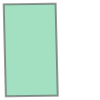

In [258]:
gdf_all.geometry[0]

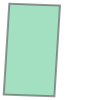

In [259]:
gdf_all.geometry[1]

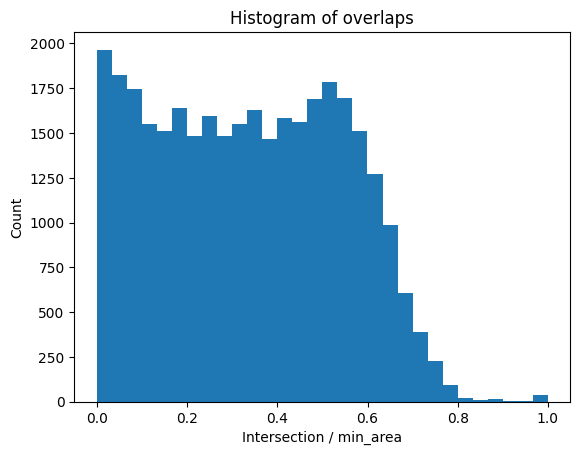

In [260]:
import matplotlib.pyplot as plt

sindex = gdf_all.sindex  # Ensure sindex is built
overlap_areas = []
for idx, geom in enumerate(gdf_all.geometry):
    possible_matches = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches:
        if other_idx == idx:
            continue
        other_geom = gdf_all.geometry.iloc[other_idx]
        if geom.intersects(other_geom):
            intersection_area = geom.intersection(other_geom).area
            min_area = min(geom.area, other_geom.area)
            if min_area > 0:
                overlap_areas.append(intersection_area / min_area)

plt.hist(overlap_areas, bins=30)
plt.xlabel('Intersection / min_area')
plt.ylabel('Count')
plt.title('Histogram of overlaps')
plt.show()


In [261]:
import geopandas as gpd

gdf = gdf_all.reset_index(drop=True)
sindex = gdf.sindex
common_idx = set()

# Threshold very close to zero for "any touch"
OVERLAP_THRESH = 1e-6

for idx, geom in enumerate(gdf.geometry):
    possible_matches = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches:
        if other_idx == idx:
            continue
        other_geom = gdf.geometry.iloc[other_idx]
        if geom.intersects(other_geom):
            intersection_area = geom.intersection(other_geom).area
            min_area = min(geom.area, other_geom.area)
            if min_area > 0 and intersection_area / min_area > OVERLAP_THRESH:
                common_idx.add(idx)
                common_idx.add(other_idx)
            elif intersection_area == 0 and geom.touches(other_geom):
                # Also count as common if they just touch (area==0, but boundaries touch)
                common_idx.add(idx)
                common_idx.add(other_idx)

gdf['group'] = 'unique'
gdf.loc[list(common_idx), 'group'] = 'common'

print("Count of 'common' (touching/overlapping) geometries:", (gdf['group'] == 'common').sum())
print("Count of 'unique' geometries:", (gdf['group'] == 'unique').sum())


Count of 'common' (touching/overlapping) geometries: 32020
Count of 'unique' geometries: 73909


In [262]:
unique_geoms = gdf_all.geometry.drop_duplicates()
print(f"Number of unique geometries: {len(unique_geoms)}")


Number of unique geometries: 105929


In [263]:
import geopandas as gpd

# Make a buffer of 0.5 meter around each geometry (requires projected CRS, not EPSG:4326)
# Project to UTM (auto) for metric units
gdf_proj = gdf_all.to_crs(gdf_all.estimate_utm_crs())
gdf_proj['buffered'] = gdf_proj.geometry.buffer(16.033)  # 0.5 meter buffer

# Use buffered geometries for overlap analysis
sindex = gdf_proj['buffered'].sindex
common_idx = set()

for idx, geom in enumerate(gdf_proj['buffered']):
    possible_matches = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches:
        if other_idx == idx:
            continue
        other_geom = gdf_proj['buffered'].iloc[other_idx]
        if geom.intersects(other_geom):
            intersection_area = geom.intersection(other_geom).area
            min_area = min(geom.area, other_geom.area)
            if min_area > 0 and intersection_area / min_area > 1e-6:
                common_idx.add(idx)
                common_idx.add(other_idx)
            elif intersection_area == 0 and geom.touches(other_geom):
                common_idx.add(idx)
                common_idx.add(other_idx)

gdf_all['grouped'] = 'unique'
gdf_all.loc[list(common_idx), 'grouped'] = 'common'

print("Count of 'common' (buffered, touching/overlapping):", (gdf_all['grouped'] == 'common').sum())
print("Count of 'unique' (buffered):", (gdf_all['grouped'] == 'unique').sum())


Count of 'common' (buffered, touching/overlapping): 43256
Count of 'unique' (buffered): 62673


In [264]:
class_counts = gdf_all.groupby(['class', 'grouped']).size().unstack(fill_value=0)
print(class_counts)
print("\nColumn-wise sum:")
print(class_counts.sum(axis=0))


grouped  common  unique
class                  
0          1573    1755
1         22565   34378
2         19118   26540

Column-wise sum:
grouped
common    43256
unique    62673
dtype: int64


In [265]:
# Class-wise, split-wise common/unique counts
result = (
    gdf_all.groupby(['split', 'class', 'grouped'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values(['split', 'class'])
)
print(result)

# For train vs test common/unique:
train = gdf_all[gdf_all['split'] == 'train']
test = gdf_all[gdf_all['split'] == 'test']
val = gdf_all[gdf_all['split'] == 'val']

# Combine as needed for (train, test), (train, val), (test, val)
for name, g1, g2 in [
    ("train/test", train, test),
    ("train/val", train, val),
    ("test/val", test, val)
]:
    both = pd.concat([g1, g2], ignore_index=True)
    cross_counts = (
        both.groupby(['class', 'grouped'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
        .sort_values('class')
    )
    print(f"\n{name} class-wise common/unique:")
    print(cross_counts)


grouped  split  class  common  unique
0         test      0     304     343
1         test      1    4391    6921
2         test      2    3890    5251
3        train      0     951    1081
4        train      1   13666   20626
5        train      2   11450   16013
6          val      0     318     331
7          val      1    4508    6831
8          val      2    3778    5276

train/test class-wise common/unique:
grouped  class  common  unique
0            0    1255    1424
1            1   18057   27547
2            2   15340   21264

train/val class-wise common/unique:
grouped  class  common  unique
0            0    1269    1412
1            1   18174   27457
2            2   15228   21289

test/val class-wise common/unique:
grouped  class  common  unique
0            0     622     674
1            1    8899   13752
2            2    7668   10527


In [211]:
import geopandas as gpd

gdf = gdf_all.reset_index(drop=True)
sindex = gdf.sindex
common_idx = set()

OVERLAP_THRESH = 0.00001  # Counts even the tiniest overlap as common

for idx, geom in enumerate(gdf.geometry):
    possible_matches = list(sindex.intersection(geom.bounds))
    for other_idx in possible_matches:
        if other_idx == idx:
            continue
        other_geom = gdf.geometry.iloc[other_idx]
        if geom.intersects(other_geom):
            intersection_area = geom.intersection(other_geom).area
            min_area = min(geom.area, other_geom.area)
            # If touching (area=0 but intersects) or small overlap
            if intersection_area > 0 and min_area > 0:
                if intersection_area / min_area > OVERLAP_THRESH:
                    common_idx.add(idx)
                    common_idx.add(other_idx)
            elif intersection_area == 0 and geom.touches(other_geom):
                common_idx.add(idx)
                common_idx.add(other_idx)

gdf['group'] = 'unique'
gdf.loc[list(common_idx), 'group'] = 'common'

print(f"Common geometries (touch or overlap >{OVERLAP_THRESH*100:.1f}%):", (gdf['group'] == 'common').sum())
print(f"Unique geometries:", (gdf['group'] == 'unique').sum())


Common geometries (touch or overlap >0.0%): 32015
Unique geometries: 73914


In [203]:
print("before",len(gdf_all))

gdf_unique = gdf_all.drop_duplicates(subset='geometry')
print(f"Number of unique geometries after dropping duplicates: {len(gdf_unique)}")


before 105929
Number of unique geometries after dropping duplicates: 105929


In [208]:
import numpy as np
from shapely.geometry import Polygon

# Threshold for "almost equal" area overlap
THRESH = 0.999

gdf = gdf_all.reset_index(drop=True)
sindex = gdf.sindex
deduped_idx = set()
visited = set()

for idx, geom in enumerate(gdf.geometry):
    if idx in visited:
        continue
    matches = list(sindex.intersection(geom.bounds))
    group = []
    for other_idx in matches:
        if other_idx == idx or other_idx in visited:
            continue
        other_geom = gdf.geometry.iloc[other_idx]
        if geom.equals_exact(other_geom, tolerance=1e-6) or \
           (geom.intersection(other_geom).area / geom.union(other_geom).area > THRESH):
            group.append(other_idx)
    visited.update(group)
    visited.add(idx)
    deduped_idx.add(idx)

print(f"Number of unique geometries after near-duplicate deduplication: {len(deduped_idx)}")


Number of unique geometries after near-duplicate deduplication: 105916


In [102]:
# Compute centroid lat/lon for each geometry and add columns
gdf_all['center_lat'] = gdf_all.geometry.centroid.y
gdf_all['center_lon'] = gdf_all.geometry.centroid.x


/tmp/ipykernel_1370097/2467380969.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_all['center_lat'] = gdf_all.geometry.centroid.y
/tmp/ipykernel_1370097/2467380969.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_all['center_lon'] = gdf_all.geometry.centroid.x


In [103]:
gdf_all

,image_name,class,geometry,split,center_lat,center_lon,center_point,center_in_other
0,29.6379_74.0288.png,1,"POLYGON ((74.03297 29.64058, 74.033 29.6395, 7...",train,29.640033,74.032677,POINT (74.03268 29.64003),False
1,29.6379_74.0288.png,1,"POLYGON ((74.03439 29.63623, 74.03505 29.63621...",train,29.635629,74.034685,POINT (74.03469 29.63563),False
2,24.8540_85.0146.png,1,"POLYGON ((85.01144 24.85198, 85.0117 24.85117,...",train,24.851527,85.011343,POINT (85.01134 24.85153),False
3,23.7261_89.5030.png,2,"POLYGON ((89.49756 23.73071, 89.49789 23.73065...",train,23.730404,89.497658,POINT (89.49766 23.7304),False
4,31.4750_73.3851.png,1,"POLYGON ((73.38709 31.47457, 73.38792 31.47408...",train,31.474171,73.387327,POINT (73.38733 31.47417),False
...,...,...,...,...,...,...,...,...
105924,27.7644_81.4985.png,1,"POLYGON ((81.49361 27.76389, 81.49459 27.76338...",test,27.763493,81.493980,POINT (81.49398 27.76349),False
105925,29.6643_77.2661.png,2,"POLYGON ((77.27013 29.66882, 77.27055 29.6685,...",test,29.668316,77.269871,POINT (77.26987 29.66832),False
105926,25.9761_88.6232.png,2,"POLYGON ((88.62826 25.97504, 88.62855 25.97441...",test,25.974662,88.628207,POINT (88.62821 25.97466),False
105927,27.4379_80.3073.png,1,"POLYGON ((80.31166 27.43625, 80.31214 27.4354,...",test,27.435737,80.311659,POINT (80.31166 27.43574),False


In [88]:
import geopandas as gpd

gdf_all = gdf_all.reset_index(drop=True)
sindex = gdf_all.sindex

common_idx = set()

for idx, geom in enumerate(gdf_all['geometry']):
    # Candidates: possible overlaps using bounding boxes (fast)
    possible_matches = list(sindex.intersection(geom.bounds))
    possible_matches = [i for i in possible_matches if i != idx]
    for i in possible_matches:
        other_geom = gdf_all.at[i, 'geometry']
        if not geom.intersects(other_geom):
            continue
        inter_area = geom.intersection(other_geom).area
        min_area = min(geom.area, other_geom.area)
        if min_area == 0:
            continue
        if inter_area / min_area > 0.000001:
            common_idx.add(idx)
            common_idx.add(i)

gdf_all['group'] = 'unique'
gdf_all.loc[list(common_idx), 'group'] = 'common'

n_unique = (gdf_all['group'] == 'unique').sum()
n_common = (gdf_all['group'] == 'common').sum()

print(f"Number of unique geometries (<10% overlap with any other): {n_unique}")
print(f"Number of common geometries (≥10% overlap with any other): {n_common}")


Number of unique geometries (<10% overlap with any other): 73909
Number of common geometries (≥10% overlap with any other): 32020


In [86]:
import geopandas as gpd

gdf_all = gdf_all.reset_index(drop=True)
sindex = gdf_all.sindex
deduped_idx = set()
visited = set()

for idx, geom in enumerate(gdf_all['geometry']):
    if idx in visited:
        continue
    # Find possible overlaps (fast bounding box filter)
    possible_matches = list(sindex.intersection(geom.bounds))
    overlaps = []
    for i in possible_matches:
        if i == idx or i in visited:
            continue
        other_geom = gdf_all.at[i, 'geometry']
        if not geom.intersects(other_geom):
            continue
        inter_area = geom.intersection(other_geom).area
        min_area = min(geom.area, other_geom.area)
        if min_area == 0:
            continue
        if inter_area / min_area > 0.10:
            overlaps.append(i)
    # Mark all overlaps (including itself) as visited, keep only idx
    visited.update(overlaps)
    visited.add(idx)
    deduped_idx.add(idx)

deduped_gdf = gdf_all.loc[list(deduped_idx)].copy()
deduped_gdf = deduped_gdf.reset_index(drop=True)

print(f"Number of deduplicated bounding boxes: {len(deduped_gdf)}")


Number of deduplicated bounding boxes: 92415


In [70]:

n_unique_images = gdf_all['image_name'].nunique()
print(f"Number of unique image_name in gdf_all: {n_unique_images}")


Number of unique image_name in gdf_all: 78690


In [56]:
# List image_names with their splits
img_split_counts = gdf_all.groupby('image_name')['split'].nunique()
common_image_names = img_split_counts[img_split_counts > 1].index.tolist()

print("Image names present in more than one split:")
print(common_image_names)


Image names present in more than one split:
[]


In [65]:
# ...build gdf_all as in previous steps...

# Spatial join (to find overlaps across splits)
joined = gpd.sjoin(gdf_all, gdf_all, how='inner', predicate='intersects')
joined = joined[joined.index != joined['index_right']]
# joined = joined[joined['split'] != joined['split_right']]

def overlap_ratio(row):
    poly1 = gdf_all.loc[row.name].geometry
    poly2 = gdf_all.loc[row['index_right']].geometry
    inter = poly1.intersection(poly2).area
    min_area = min(poly1.area, poly2.area)
    return inter / min_area if min_area > 0 else 0

joined['overlap_ratio'] = joined.apply(overlap_ratio, axis=1)
common_idx = set(joined[joined['overlap_ratio'] >= 0.1].index)

gdf_all['group'] = 'unique'
gdf_all.loc[list(common_idx), 'group'] = 'common'


In [66]:
common_gdf = gdf_all[gdf_all['group'] == 'common']
# print(common_gdf[['image_name', 'class', 'geometry']])
print(len(common_gdf))


26948


In [67]:
import os

# Define paths
train_images_dir = "/home/suruchi.hardaha/cosmos/ijcai_2025_data/symlinked_AA_DATA/train_afghanistan_bangladesh_india_test_pakistan/train/images"
train_labels_dir = "/home/suruchi.hardaha/cosmos/ijcai_2025_data/symlinked_AA_DATA/train_afghanistan_bangladesh_india_test_pakistan/train/labels"
test_images_dir = "/home/suruchi.hardaha/cosmos/ijcai_2025_data/symlinked_AA_DATA/train_afghanistan_bangladesh_india_test_pakistan/test/images"
test_labels_dir = "/home/suruchi.hardaha/cosmos/ijcai_2025_data/symlinked_AA_DATA/train_afghanistan_bangladesh_india_test_pakistan/test/labels"

def collect_image_label_pairs(images_dir, labels_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.png') or f.endswith('.jpg')]
    pairs = []
    for img in image_files:
        label = os.path.splitext(img)[0] + '.txt'
        label_path = os.path.join(labels_dir, label)
        img_path = os.path.join(images_dir, img)
        if os.path.exists(label_path):
            pairs.append((img_path, label_path))
        else:
            print(f"Label missing for image: {img}")
    return pairs

train_pairs = collect_image_label_pairs(train_images_dir, train_labels_dir)
test_pairs = collect_image_label_pairs(test_images_dir, test_labels_dir)

print(f"Train image-label pairs: {len(train_pairs)}")
print(f"Test image-label pairs: {len(test_pairs)}")

# Example access:
# for img_path, label_path in train_pairs:
#     print(img_path, label_path)


Train image-label pairs: 63810
Test image-label pairs: 14882


In [71]:
import os

def count_label_entries(label_dir):
    total_entries = 0
    file_counts = []
    for fname in os.listdir(label_dir):
        if fname.endswith('.txt'):
            path = os.path.join(label_dir, fname)
            with open(path, 'r') as f:
                lines = f.readlines()
                n = len(lines)
                total_entries += n
                file_counts.append((fname, n))
    return total_entries, file_counts

train_label_dir = "/home/suruchi.hardaha/cosmos/ijcai_2025_data/symlinked_AA_DATA/train_afghanistan_bangladesh_india_test_pakistan/train/labels"
test_label_dir = "/home/suruchi.hardaha/cosmos/ijcai_2025_data/symlinked_AA_DATA/train_afghanistan_bangladesh_india_test_pakistan/test/labels"

train_total, train_file_counts = count_label_entries(train_label_dir)
test_total, test_file_counts = count_label_entries(test_label_dir)

print(f"Total label entries in train: {train_total}")
print(f"Total label entries in test: {test_total}")
# Optional: print per file
# print(train_file_counts)
# print(test_file_counts)


Total label entries in train: 85374
Total label entries in test: 20559
